In [1]:
import gc
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pylab as plt
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Polygon
from dateutil.relativedelta import relativedelta
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
from statsmodels.tsa.seasonal import seasonal_decompose
import pywt

## 1. Fetch the data

In [2]:
calendar=pd.read_csv('C:/Users/123456/Desktop/AI final/acc/calendar.csv')
sales_train_eva=pd.read_csv('C:/Users/123456/Desktop/AI final/acc/sales_train_evaluation.csv')  
sales_train_val=pd.read_csv('C:/Users/123456/Desktop/AI final/acc/sales_train_validation.csv') 
selling_prices=pd.read_csv('C:/Users/123456/Desktop/AI final/acc/sell_prices.csv')
sample_submission = pd.read_csv('C:/Users/123456/Desktop/AI final/acc/sample_submission.csv')

In [3]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [4]:
sales_train_val.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [5]:
selling_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

## EDA

In [6]:
sales_train_val.isna().sum().sum()

0

There are no missing values in our sales training validation data.

In [7]:
def disp_boxplot(data, title, xlabel, ylabel):
    sns.set_style('whitegrid')
    sns.set_context('poster')
    palette = sns.color_palette("mako_r", 6)
    
    ax = sns.boxplot(data=data, palette = palette)
    ax.set(title = title,
          xlabel = xlabel,
          ylabel = ylabel)
    
    try:
        ax.axhline(y = data.mean().mean(), color = 'b', label = 'Mean of all datapoints', linestyle = '--', linewidth = 1.5)
        ax.ahline(y = data.median().median(), color = 'g', label = 'Median of all datapoints', linestyle = '--', linewidth = 1.5)
    except:
                pass
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    
    plt.legend()
    plt.show()

In [8]:
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
past_sales = sales_train_val.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

In [9]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values(ascending=False).index[0],
     'with', past_sales.sum(axis=1).sort_values(ascending=False).values[0], 'sales')

The lowest sale date was: 2012-12-25 with 11 sales
The lowest sale date was: 2016-03-06 with 57218 sales


It appears that walmarts are closed on Chirstmas day. 
The highest demand day of all the data was on Sunday March 6th, 2016. The Seventh Democratic presidential candidates debate hosted by CNN on that, which may impact sales.

### Total sales and mean sales by different State ID

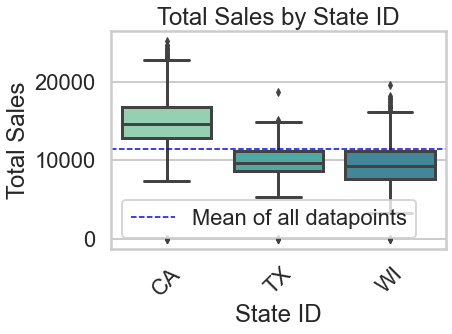

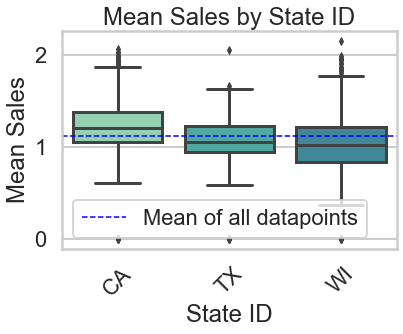

In [10]:
state_sum = sales_train_val.groupby(['state_id']).sum().T.reset_index(drop = True)
state_mean = sales_train_val.groupby(['state_id']).mean().T.reset_index(drop = True)

disp_boxplot(data = state_sum, title = 'Total Sales by State ID',
            xlabel = "State ID", ylabel = "Total Sales")

disp_boxplot(data = state_mean, title = 'Mean Sales by State ID',
            xlabel = "State ID", ylabel = "Mean Sales")

The total sales in CA are significantly high while the mean sales of it are not. In order to find the reason, we showe stores owned by different state ID.

In [11]:
selling_prices['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

We can find that CA has 4 stores while TX and WI have 3. This may show that the total sales being higher in CA are simply due to there being 4 stores in the dataset instead of 3 like with TX and WI.

### Total sales and mean sales by different Store ID

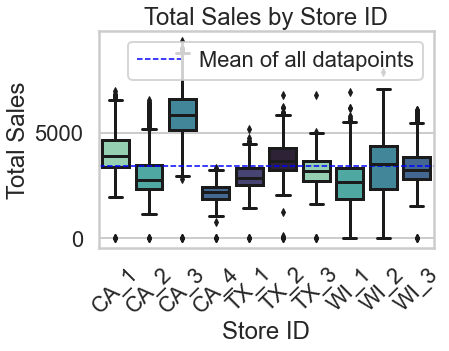

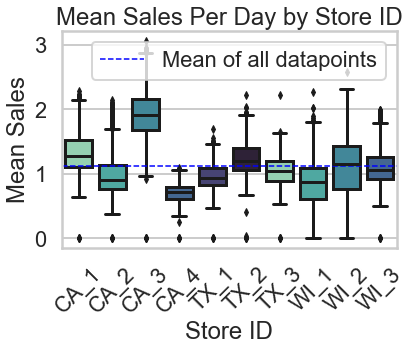

In [12]:
store_sum = sales_train_val.groupby(['store_id']).sum().T.reset_index(drop = True)
store_mean = sales_train_val.groupby(['store_id']).mean().T.reset_index(drop = True) 

disp_boxplot(data = store_sum, title = 'Total Sales by Store ID',
            xlabel = "Store ID", ylabel = "Total Sales")


disp_boxplot(data = store_mean, title = 'Mean Sales Per Day by Store ID',
            xlabel = "Store ID", ylabel = "Mean Sales")

While CA_3 makes the most sales, CA_2 is similar to other stores and CA_4 is fairly low. Even though CA does have more overall mean sales, this may be because CA_3 is significantly higher than all the others.

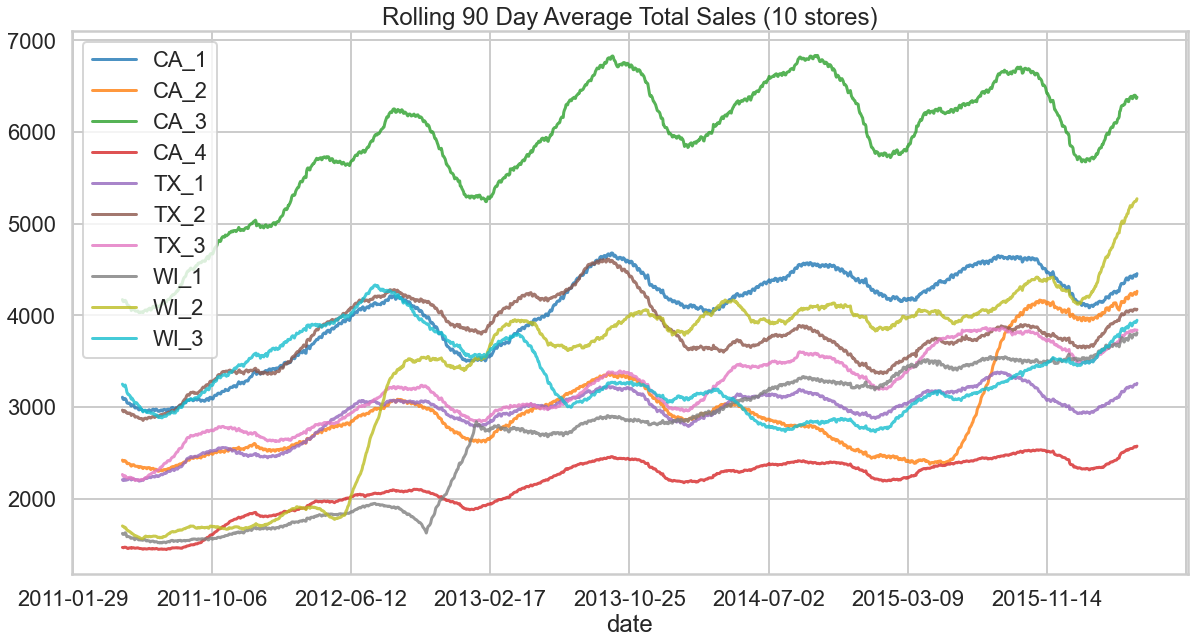

In [13]:
#We are provided the rolling 90 day average total sales for 10 unique stores. 

store_list = selling_prices['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items].sum(axis=1).rolling(90).mean().plot(figsize=(20, 10),alpha=0.8,title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()


Note that some stores are more steady than others.
CA_2 seems to have a big change occur in 2015

### Total sales by different categories

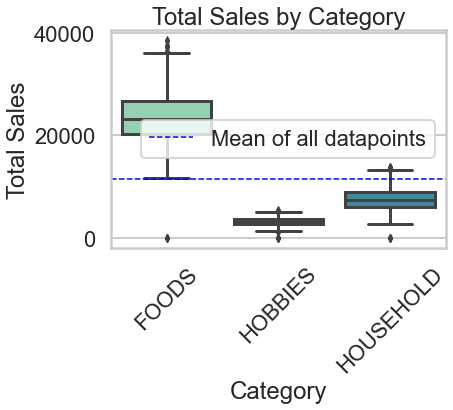

In [14]:
cat_sum = sales_train_val.groupby(['cat_id']).sum().T.reset_index(drop = True)
disp_boxplot(data = cat_sum, title = 'Total Sales by Category',
            xlabel = "Category", ylabel = "Total Sales")

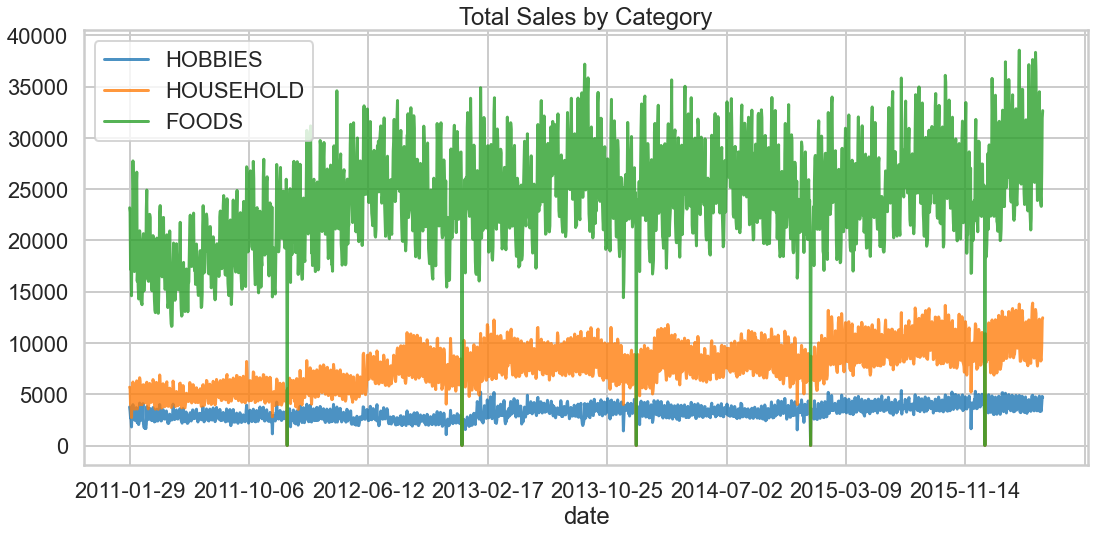

In [15]:
for i in sales_train_val['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(18, 8),alpha=0.8,title='Total Sales by Category')
plt.legend(sales_train_val['cat_id'].unique())
plt.show()

There are only three item types of sales data, "HOBBIES", "HOUSEHOLD" and "FOODS".
FOODS has the most items and the most sales, followed by HOUSEHOLD and HOBBIES.

The sales of three item types in 2013, 2014 and 2015.

In [16]:
def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7
        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
     # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

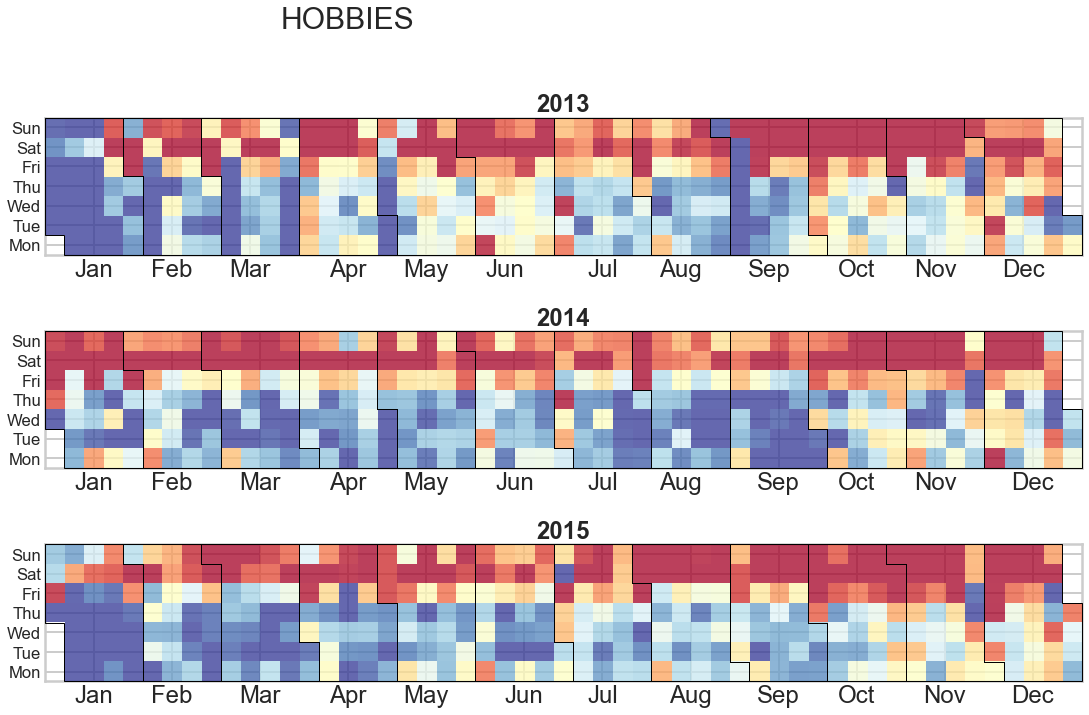

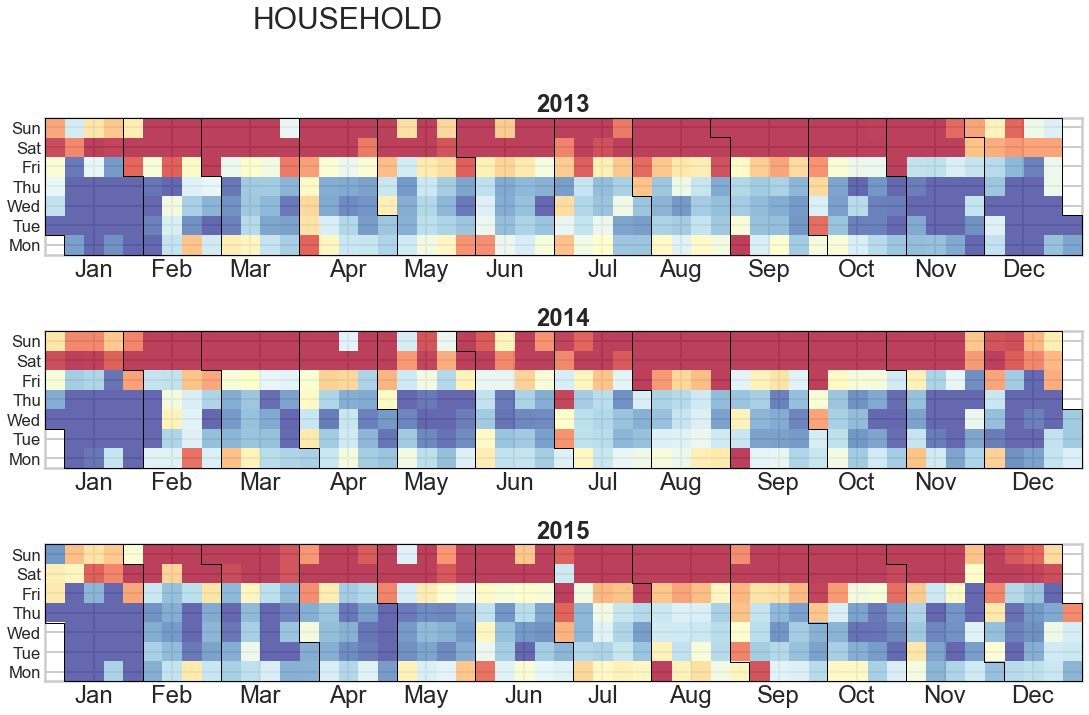

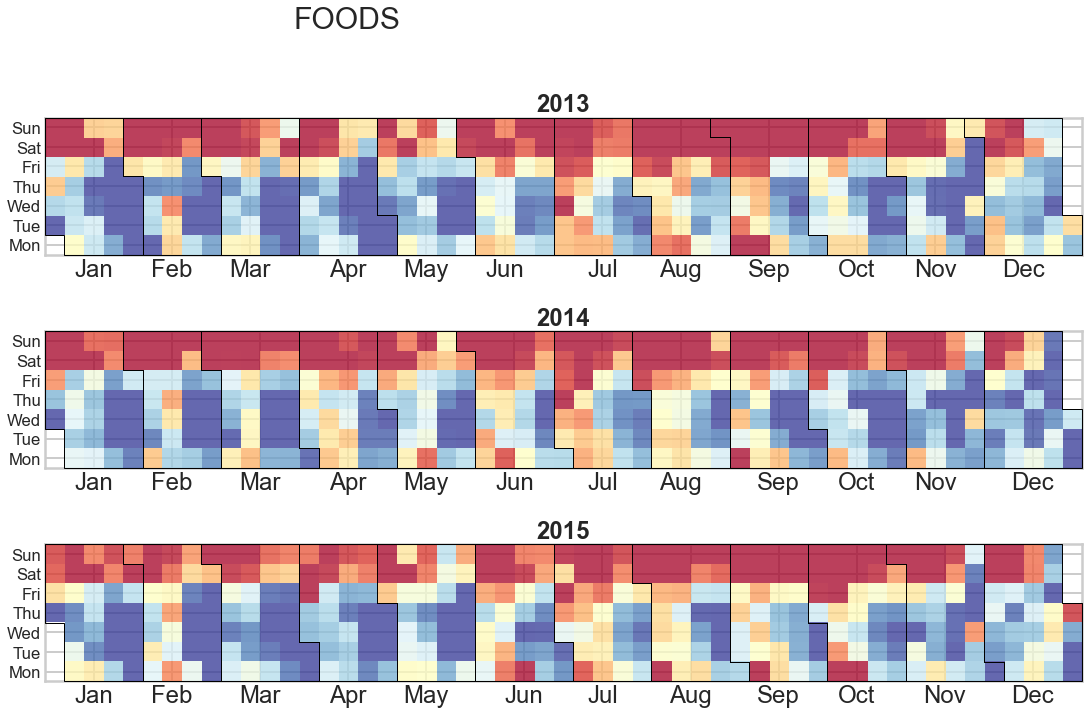

In [17]:
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in sales_train_val['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(30, 10))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

Foods tends to have lower number of purchases as the month goes on.
Household and Hobbies items sell much less in January（after the Holiday season is over）.
Clearly, weekends are more popular shopping days regardless of the item categories.

### Total sales by different departments.

In [18]:
dept_sales = sales_train_val.groupby(['dept_id']).mean().mean()
dept_sum = sales_train_val.groupby(['dept_id']).sum().T.reset_index(drop = True)

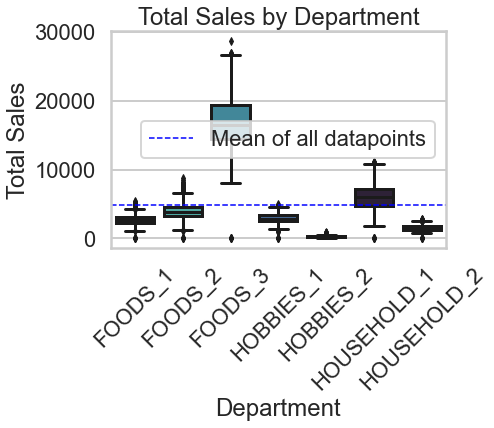

In [19]:
disp_boxplot(data = dept_sum, title = 'Total Sales by Department',
            xlabel = "Department", ylabel = "Total Sales")

We can see that Foods_3 and household_1 make the most total sales. In order to check whether stores have more of one type of item than another, we caluculate the Number of items in each category per store.

store_id     CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3
dept_id                                                                
FOODS_1       216   216   216   216   216   216   216   216   216   216
FOODS_2       398   398   398   398   398   398   398   398   398   398
FOODS_3       823   823   823   823   823   823   823   823   823   823
HOBBIES_1     416   416   416   416   416   416   416   416   416   416
HOBBIES_2     149   149   149   149   149   149   149   149   149   149
HOUSEHOLD_1   532   532   532   532   532   532   532   532   532   532
HOUSEHOLD_2   515   515   515   515   515   515   515   515   515   515


[Text(0.5, 1.0, 'Number of items in each category per store - Uniform')]

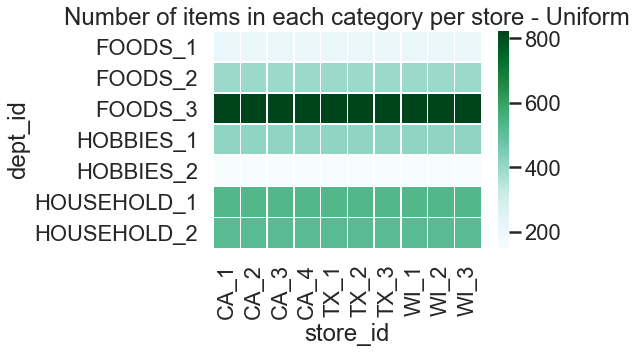

In [20]:
dept_storeloc_cross = pd.crosstab(sales_train_val['dept_id'], sales_train_val['store_id'])
print(dept_storeloc_cross)
ax = sns.heatmap(dept_storeloc_cross,
                linewidths = 0.4,
                cmap="BuGn")
ax.set(title = 'Number of items in each category per store - Uniform')

All stores have the same kind of items.

### Sample Item ID

#### We choose a sample item and see its sale price over time in different stores. 

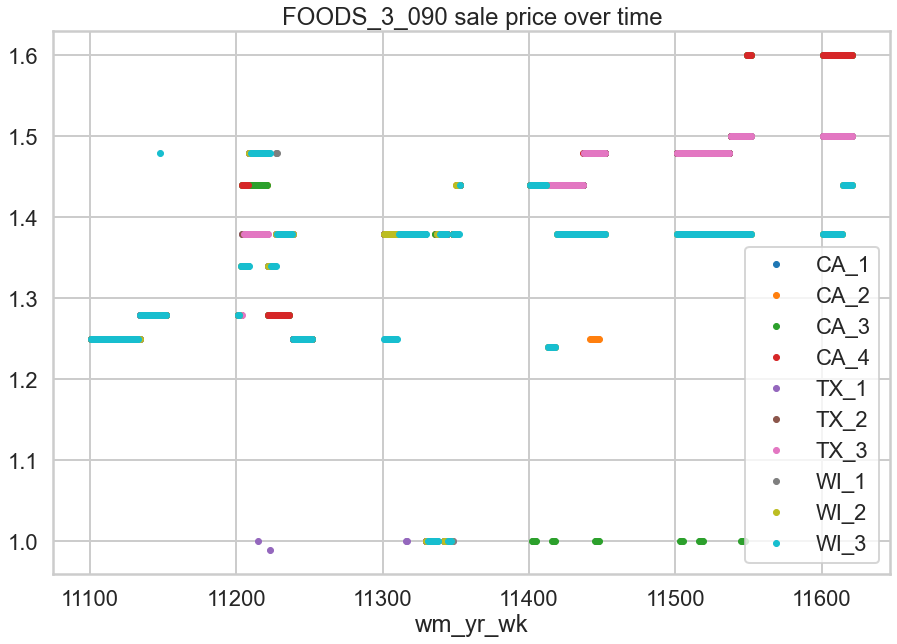

In [28]:
fig, ax = plt.subplots(figsize=(1, 3))
stores = []
for store, d in selling_prices.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          figsize=(15, 10),
          title='FOODS_3_090 sale price over time',
         ax=ax,
          legend=store)
    stores.append(store)
    plt.legend()
plt.legend(stores)
plt.show()

We choose "FOODS_3_090" as our example item and give the historical sale prices of it.
We can find that the price of this item is growing with time. And at the same time period, different stores have different selling prices.

### Instability

In [22]:
# Randomly select the sales data of different stores from the dataset.
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[6]].set_index('id')[d_cols].values[0]


fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False, mode='lines', name="First sample",marker=dict(color="teal")),row=1, col=1)

fig.update_layout(height=500, width=800, title_text="Sample sales")
fig.show()

In [23]:
# Randomly select the sales data of different stores from the dataset.
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[6]].set_index('id')[d_cols].values[0]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[10]].set_index('id')[d_cols].values[0]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[21]].set_index('id')[d_cols].values[0]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False, mode='lines', name="First sample",marker=dict(color="teal")),row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,mode='lines', name="Second sample",marker=dict(color="maroon")),row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,mode='lines', name="Third sample",marker=dict(color="navy")),row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales")
fig.show()

 The sales data is very erratic, owing to the fact that so many factors affect the sales on a given day. On certain days, the sales quantity is zero, which indicates that a certain product may not be available on that day.

In [24]:
#In order to make the results clearer, we simply zoom in to sample snippets in the sales data of the above three stores.
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[6]].set_index('id')[d_cols].values[0][:90]

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="teal")),
             row=1, col=1)


fig.update_layout(height=500, width=800, title_text="Sample sales snippets")
fig.show()

In [25]:
#In order to make the results clearer, we simply zoom in to sample snippets in the sales data of the above three stores.
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[6]].set_index('id')[d_cols].values[0][:90]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[10]].set_index('id')[d_cols].values[0][1300:1400]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[21]].set_index('id')[d_cols].values[0][350:450]
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="teal")),
             row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="Second sample",
                         marker=dict(color="maroon")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="Third sample",
                         marker=dict(color="navy")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales snippets")
fig.show()

Then, we can clearly see that the sales data is very erratic and volatile. Sometimes, the sales are zero for a few days in a row, and at other times, it remains at its peak value for a few days. Therefore, we need to de-noise the data to find the underlying trends in the sales data and make forecasts.

### Seaonality and Trend

We use CA_1 store as an example to do seasonal decomposition and analyze the seaonality and trend of our dataset.

Yearly Cycle Decompose of CA_1 store

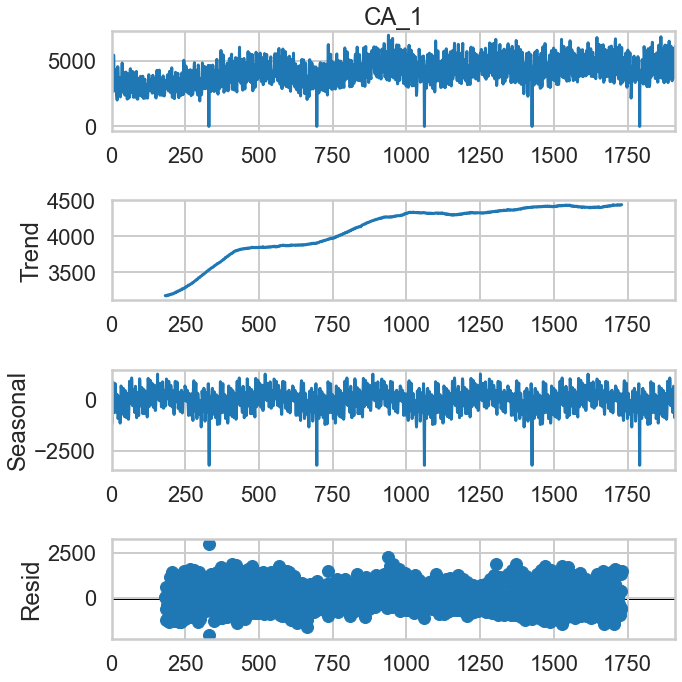

In [26]:
weeks_per_year = 365

time_series = store_sum["CA_1"]
plt.rcParams.update({'figure.figsize': (10, 10)})
sj_sc = seasonal_decompose(time_series, period = weeks_per_year)
sj_sc.plot()

plt.show()

The instability, seaonality and trend of our data is the reason why we choose SARIMA.
Because the SARIMA model has parameters to take care of these problems for us (the d or diff parameter).